# Very Simple Linear Regression

Try a simple linear regression based model for predicting cross-domain correlation structures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import sys

In [3]:
sys.path.append("..")
from mlcdc import KerasFeeder

In [4]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')

### Quick look at correlations

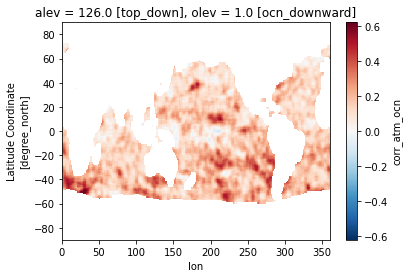

In [5]:
ds.corr_atm_ocn.isel(olev=0,alev=-1).plot()

## Prepare the data

In [6]:
kf = KerasFeeder(feature_names=['ocn_Temp',
                                'atm_T',
                                'ocn_MLD',
                                'atm_speed_surf'],
                 label_name='corr_atm_ocn',
                 mask_name='ocn_mask',
                 training_fraction=0.8,
                 load_into_memory=True)

In [7]:
kf

KerasFeeder:

    Features:
        ocn_Temp, atm_T, ocn_MLD, atm_speed_surf
        status = unset

    Labels:
        corr_atm_ocn
        status = unset

    Inputs:
        None
        status = unset

 --- 
    Training Fraction       : 0.8
    Normalize Data          : True
    Load into Memory        : True

In [8]:
ds['atm_speed_surf'] = ds.atm_wind_speed.isel(alev=-1)

In [9]:
kf(ds)

In [10]:
kf

KerasFeeder:

    Features:
        ocn_Temp, atm_T, ocn_MLD, atm_speed_surf
        status = set

    Labels:
        corr_atm_ocn
        status = set

    Inputs:
        [<KerasTensor: shape=(None, 44) dtype=float32 (created by layer 'ocn_Temp')>, <KerasTensor: shape=(None, 74) dtype=float32 (created by layer 'atm_T')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ocn_MLD')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'atm_speed_surf')>]
        status = set

 --- 
    Training Fraction       : 0.8
    Normalize Data          : True
    Load into Memory        : True

## Create the model

For vector valued input (e.g. `ocn_Temp`), keras wants this to be organized with the vector as the last dimension, hence the reordering of dimensions earlier

Create each input layer

Then merge it all together

In [11]:
merge = keras.layers.concatenate(kf.inputs)

For now, using merged vertical coordinate

In [12]:
output = keras.layers.Dense(
    units=len(kf.labels['training'].z), name="ao_corr",
    #kernel_regularizer=keras.regularizers.L1(1e-3)
    #kernel_regularizer=keras.regularizers.L1L2(5e-4,5e-4)
    kernel_regularizer=keras.regularizers.L2(1e-3)
)(merge)

2022-07-29 14:31:18.588924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model = keras.Model(
    inputs=kf.inputs,
    outputs=[output]
)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ocn_Temp (InputLayer)          [(None, 44)]         0           []                               
                                                                                                  
 atm_T (InputLayer)             [(None, 74)]         0           []                               
                                                                                                  
 ocn_MLD (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 atm_speed_surf (InputLayer)    [(None, 1)]          0           []                               
                                                                                              

Size is bias vector + matrix ... good

In [15]:
74*44 + 120*(74*44)

393976

### Determine optimization process and train it

For now, use MSE loss function and Adam optimization.
Options in [keras regression losses](https://keras.io/api/losses/regression_losses/)
and [keras optimizers](https://keras.io/api/optimizers/) 

- What learning rate to use?
- What regularization type and parameter to use?
- How to do this in parallel rather than pulling everything into memory here?

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.05 #no idea on hyper parameters)
    ),
    loss=keras.losses.MeanSquaredError()
)

In [19]:
%%time
history = model.fit(
    x={k:kf.features['training'][k].values for k in kf.feature_names}, 
    y=kf.labels['training'].values,
    epochs=20,
    batch_size=512,
    validation_split=0.2,
)

Epoch 1/20
124/124 [==============================] - 3s 22ms/step - loss: 0.6988 - val_loss: 0.0032
Epoch 2/20
124/124 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 3/20
124/124 [==============================] - 3s 21ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 4/20
124/124 [==============================] - 3s 21ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 5/20
124/124 [==============================] - 3s 20ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
124/124 [==============================] - 2s 19ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/20
124/124 [==============================] - 3s 21ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 8/20
124/124 [==============================] - 3s 20ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 9/20
124/124 [==============================] - 2s 20ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 10/20
124/124 [==============================] - 3s 21ms/step - loss: 0.0100 - val_lo

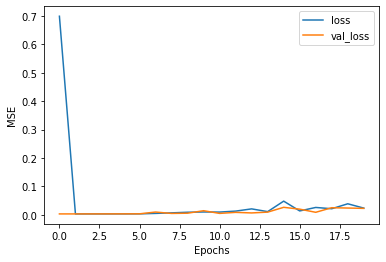

In [20]:
fig,ax=plt.subplots()
for key in ['loss','val_loss']:
    ax.plot(history.history[key],label=key)
ax.set(xlabel='Epochs', ylabel='MSE')
ax.legend()

Without regularization, this loss curve looked like a random process. Now it's actually (mostly) decreasing.

In [21]:
model.evaluate(
    x={k:kf.features['testing'][k].values for k in kf.feature_names}, 
    y=kf.labels['testing'].values
)

619/619 [==============================] - 2s 3ms/step - loss: 0.0224


0.022439099848270416

In [22]:
prediction = model.predict({k:kf.features['testing'][k].values for k in kf.feature_names})

619/619 [==============================] - 1s 1ms/step


In [23]:
xpred = xr.DataArray(prediction,coords=kf.labels['testing'].coords, dims=kf.labels['testing'].dims)

In [24]:
xpred = xpred.unstack('z')

[Text(0.5, 0, 'Truth'), Text(0, 0.5, 'Prediction')]

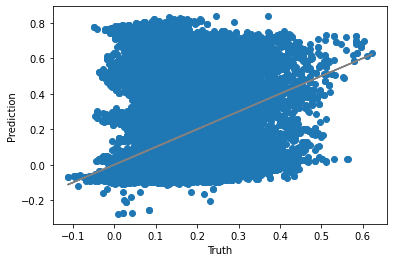

In [25]:
fig, ax = plt.subplots()
ax.scatter(kf.labels['testing'].unstack('z').isel(alev=-1,olev=0),
           xpred.isel(alev=-1,olev=0),
          )
ax.plot(kf.labels['testing'].unstack('z').isel(alev=-1,olev=0),
        kf.labels['testing'].unstack('z').isel(alev=-1,olev=0),
        color='gray')
ax.set(xlabel='Truth',ylabel='Prediction')

💩